In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import astropy.units as u
from astropy.io import fits
from pathlib import Path
from IPython.display import clear_output
from importlib import reload
import copy
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
import os
from pathlib import Path
import time

import magpyx
from magpyx.utils import ImageStream
import purepyindi
from purepyindi import INDIClient
client0 = purepyindi.INDIClient('localhost', 7624)
client0.start()

from math_module import xp, xcipy, np_array
import utils
import fsm_utils
import cam_utils
from imshows import imshow1, imshow2, imshow3
from matplotlib.patches import Circle

wavelength = 633e-9
fl = 400e-3
fsm_pupil_diam = 6.8e-3
as_per_lamD = (wavelength/fsm_pupil_diam*u.radian).to(u.arcsec)
print(as_per_lamD)

pxscl_lamD = 3.45e-6 / (fl * wavelength/fsm_pupil_diam)
print(1/pxscl_lamD)

v_bias = np.array([[50,50,50]]).T


19.200826816825295 arcsec
10.792838874680308


In [3]:
pxscl_lamD * as_per_lamD, 20*u.arcsec/as_per_lamD

(<Quantity 1.77903395 arcsec>, <Quantity 1.04162181>)

In [7]:
reload(cam_utils)
cam = cam_utils.CAM('campupil')


In [4]:
npsf = 200
cam.set_roi(560, 900, npsf, client0)

In [5]:
cam.set_exptime(0.0002, client0)

INFO:utils:Got semaphore index 1.


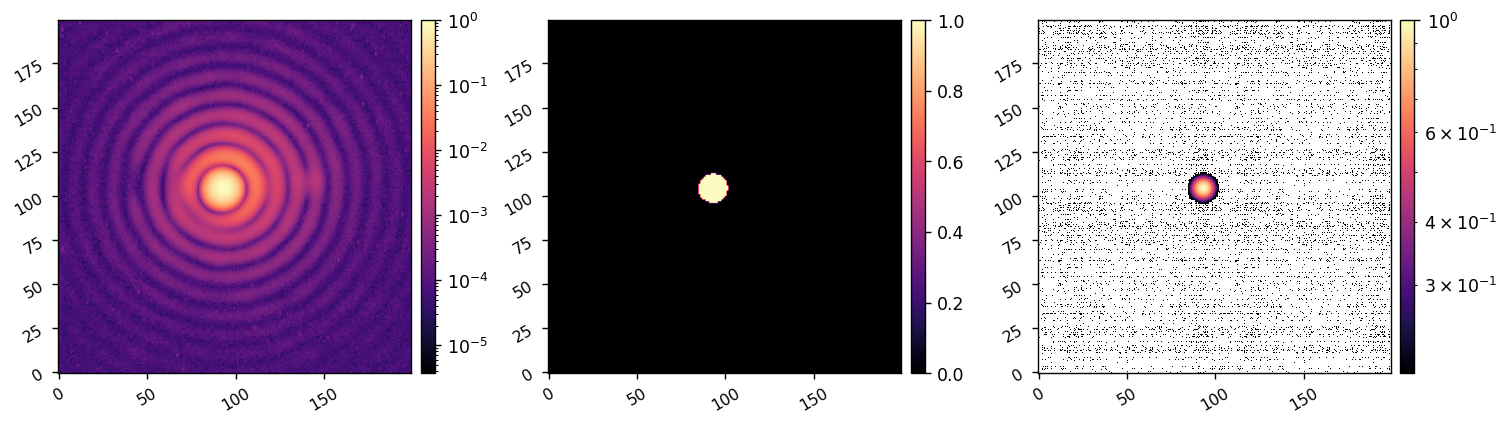

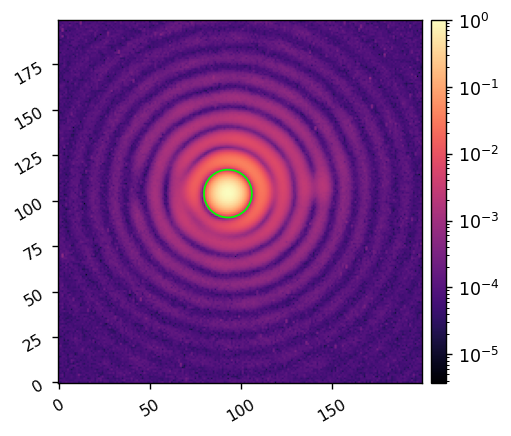

In [8]:
cam.Nframes = 1000
im = cam.snap()

reload(utils)
cen = utils.centroid(im, thresh=0.2, plot=True)
imshow1(im, lognorm=True, patches=[Circle(cen, 1.22/pxscl_lamD, fill=False, color='lime')])


In [9]:
fsm = ImageStream('fsm')
fsm.write(v_bias)

In [2]:
rc1 = xp.arange(2, 20, 2) # as
rc2 = xp.arange(20, 50, 5) # as
r_samples = xp.concatenate([rc1, rc2])
Nr = len(r_samples)
print(Nr)

delr = xp.zeros(Nr)
delr[0] = r_samples[1] - r_samples[0]
delr[1:] = r_samples[1:] - r_samples[:-1]

delth = 45
Nth = int(360/delth)
print(Nth)

Npc = Nr * Nth
print(Npc)

rc = xp.zeros(Npc)
thc = xp.zeros(Npc)
areas = xp.zeros(Npc)
for i in range(len(r_samples)):
    r = r_samples[i]
    if i%2==0:
        th_samples = xp.arange(0, 360, delth)
    else: 
        th_samples = xp.arange(0, 360, delth) + delth/2

    rc[i*Nth:(i+1)*Nth] = xp.array([r]*Nth)
    thc[i*Nth:(i+1)*Nth] = th_samples
    
    if i==0:
        Router = r + delr[i]/2
        area = 1/2 * (delth * xp.pi/180) * (Router**2)
        print(Router)
    else:
        Rinner = r - delr[i-1]/2
        Router = r + delr[i]/2
        area = 1/2 * (delth * xp.pi/180) * (Router**2 - Rinner**2)
        print(Rinner, Router)
    areas[i*Nth:(i+1)*Nth] = xp.array([area]*Nth)

pointing_coords = xp.array([rc * xp.cos(thc*np.pi/180), rc * xp.sin(thc*np.pi/180)]).T
print(pointing_coords.shape)

15
8
120
3.0
3.0 5.0
5.0 7.0
7.0 9.0
9.0 11.0
11.0 13.0
13.0 15.0
15.0 17.0
17.0 19.0
19.0 21.0
24.0 27.5
27.5 32.5
32.5 37.5
37.5 42.5
42.5 47.5
(120, 2)


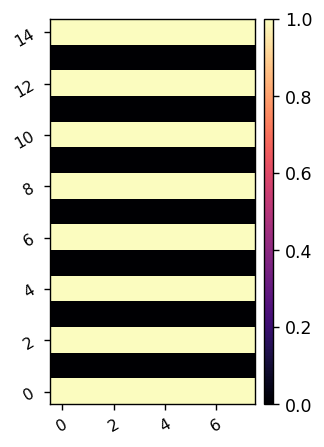

Saved data to:  data/hysteresis/20241024_test_sampling.fits


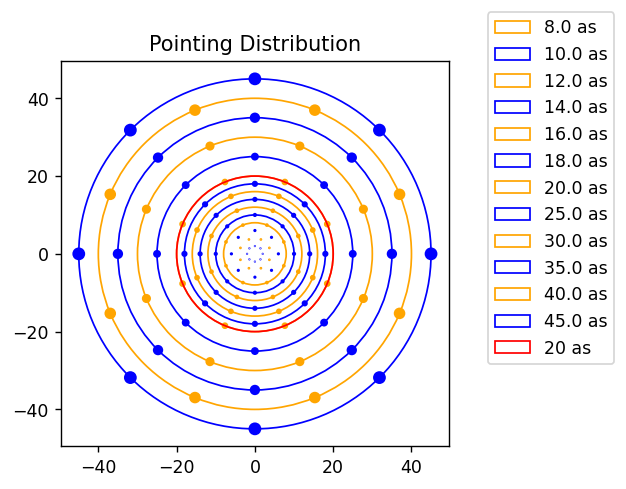

In [4]:
mask = xp.zeros((len(r_samples), Nth)).astype(bool)
mask[::2] = 1
imshow1(mask)

fig = plt.figure(dpi=125, figsize=(4,4))

ax1 = plt.subplot(111)
# ax1.scatter(np_array(pointing_coords[:,0]), np_array(pointing_coords[:,1]), s=1*rc**2)
# ax1.scatter(np_array(pointing_coords[:,0]), np_array(pointing_coords[:,1]), s=10*areas.get())
ax1.scatter(np_array(pointing_coords[mask.ravel(),0]), np_array(pointing_coords[mask.ravel(),1]), 
            color='blue', s=np_array(rc[mask.ravel()]**2)/50)
ax1.scatter(np_array(pointing_coords[~mask.ravel(),0]), np_array(pointing_coords[~mask.ravel(),1]), 
            color='orange', s=np_array(rc[~mask.ravel()]**2)/50)
ax1.set_title('Pointing Distribution')

for i in range(Nr):
    r = r_samples[i]
    if r>6:
        if i%2==0: 
            color='blue'
        else: 
            color='orange'
        ax1.add_patch(Circle((0,0), r, fill=False, color=color, label=f'{r:.1f} as'))
ax1.add_patch(Circle((0,0), 20, fill=False, color='red', label='20 as'))
ax1.legend(bbox_to_anchor=(1.45, 1.15))

utils.save_fits(f'data/hysteresis/{today}_test_sampling.fits', pointing_coords, header={'NTH':Nth, 'NR':Nr})

In [19]:
fsm = ImageStream('fsm')
fsm.write(v_bias)

Displacements: A = 6.07e-06 m, 3.54e-06 m, 5.39e-06 m. 
Delta Voltages: A = 60.69, B = 35.40, C = 53.91. 


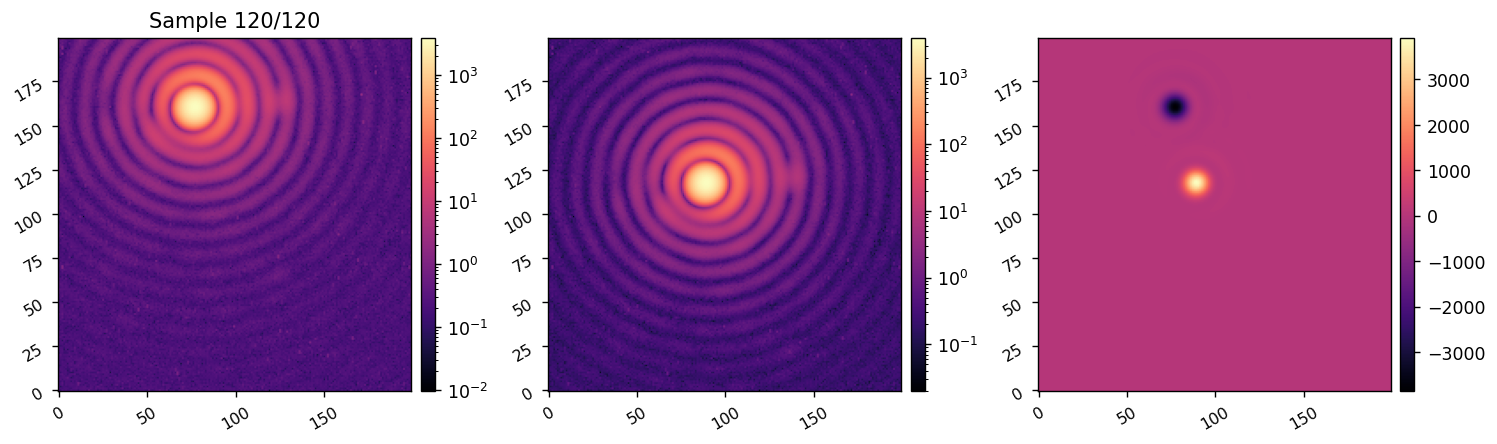

In [16]:
cam.Nframes = 5000

ims = np.zeros((3*Npc, npsf, npsf))
for i in range(Npc):
    fsm.write(0*v_bias)
    time.sleep(0.5)

    fsm.write(v_bias)
    time.sleep(0.5)
    ims[3*i] = cam.snap()

    v = fsm_utils.get_fsm_volts(tip=float(pointing_coords[i][0])*u.arcsec, tilt=float(pointing_coords[i][1])*u.arcsec, )
    fsm.write(v)
    time.sleep(0.5)
    ims[3*i + 1] = cam.snap()

    fsm.write(v_bias)
    time.sleep(0.5)
    ims[3*i + 2] = cam.snap()


    imshow3(ims[3*i+1], ims[3*i+2], ims[3*i+2]-ims[3*i+1], f'Sample {i+1}/{Npc}', lognorm1=True, lognorm2=True)
    clear_output(wait=True)


In [17]:
hdr = {
    'EXPTIME':client0[f'campupil.exptime.current'],
    'NEXPS':cam.Nframes, 
    'FPS':client0[f'campupil.fps.current'], 
}
utils.save_fits(f'data/hysteresis/{today}_test_images_2.fits', ims, header=hdr, ow=True)
utils.save_fits(f'data/hysteresis/{today}_test_sampling.fits', pointing_coords)

Saved data to:  data/hysteresis/20241023_test_images_2.fits
Saved data to:  data/hysteresis/20241023_test_sampling.fits
